In [1]:
import requests
import pandas as pd
from pymongo import MongoClient
from datetime import datetime
import plotly.express as px
from geopy.geocoders import Nominatim
import time
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import interact

# Define the API endpoint and parameters
url = "https://api.fda.gov/food/enforcement.json?search=report_date:[20200101+TO+20241005]&limit=500"

# Send a GET request to the API
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    recalls = data.get('results', [])
    recall_df = pd.DataFrame(recalls)

    clean_df = recall_df.rename(columns={
        "status": "Status", 
        "city": "City",
        "state": "State",
        "country":"Country",
        "classification":"Classification",
        "openfda":"Open FDA",
        "product_type":"Product Type",
        "event_id":"Event ID",
        "recalling_firm":"Recalling Firm",
        "address_1":"Address 1",
        "address_2":"Address 2",
        "postal_code":"Postal Code",
        "voluntary_mandated":"Voluntary Mandated",
        "initial_firm_notification":"Initial Firm Notification",
        "distribution_pattern":"Distribution Pattern",
        "recall_number":"Recall Number",
        "product_description":"Product Description",
        "product_quantity":"Product Quantity",
        "reason_for_recall":"Reason for Recall",
        "recall_initiation_date":"Recall Initiation Date",
        "center_classification_date":"Center Classification Date",
        "termination_date":"Termination Date",
        "report_date":"Report Date",
        "code_info":"Code Info",
        "more_code_info":"More Code Info",
    })

    # Convert DataFrame to dictionary format for MongoDB
    recall_records = clean_df.to_dict("records")

    # Connect to MongoDB
    client = MongoClient('mongodb://localhost:27017/')  # Or use your MongoDB URI
    db = client['fda_recall_data']  # Database name
    collection = db['recalls']  # Collection name

    # Insert modified data into MongoDB
    collection.insert_many(recall_records)

    # Example: Query data back from MongoDB
    recalls_from_db = list(collection.find())

    # Convert back to DataFrame if needed
    db_df = pd.DataFrame(recalls_from_db)
    
else:
    print(f"Failed to retrieve data: {response.status_code}")

In [11]:
# # Connect to MongoDB
# client = MongoClient('mongodb://localhost:27017/')  # Replace with your MongoDB URI if necessary
# db = client['fda_recall_data']  # Database name
# collection = db['recalls']  # Collection name

# Query MongoDB and load the data into a pandas DataFrame
recalls_cursor = collection.find({"State": {"$ne": ""}}, {"State": 1, "_id": 0})  # Fetch state data only
recalls_df = pd.DataFrame(list(recalls_cursor))

# Ensure the 'state' column exists and clean it
if 'State' in recalls_df.columns:
    recalls_df['State'] = recalls_df['State'].str.upper()  # Ensure all state abbreviations are uppercase

# Group by state and count the number of recalls per state
state_counts = recalls_df.groupby('State').size().reset_index(name='Count')

# Create Plotly choropleth map
fig = px.choropleth(
    state_counts, 
    locations='State', 
    locationmode="USA-states",  # Use state abbreviations for location matching
    color='Count', 
    color_continuous_scale="YlGnBu",  # Green-Blue color scale
    scope="usa",  # Limit the map to USA
    title="FDA Recalls by State"
)

# Customize the layout (optional)
fig.update_layout(
    geo=dict(
        lakecolor='rgb(255, 255, 255)'  # Set lake color to white
    )
)

# Save the figure as an interactive HTML file
fig.write_html("./output_data/fda_recalls_by_state.html")

# Optional: Show the figure in a notebook or browser (for testing or interactive use)
fig.show()

In [12]:
# List of all 50 U.S. state abbreviations
us_states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME',
    'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA',
    'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'DC'
]

# Query MongoDB and load the data into a pandas DataFrame
recalls_cursor = collection.find({"State": {"$ne": ""}}, {"State": 1, "_id": 0})  # Fetch state data only
recalls_df = pd.DataFrame(list(recalls_cursor))

# Ensure the 'State' column exists and clean it
if 'State' in recalls_df.columns:
    recalls_df['State'] = recalls_df['State'].str.upper()  # Ensure all state abbreviations are uppercase

    # Get unique states present in the dataset
    states_in_dataset = recalls_df['State'].unique()

    # Find states that are missing from the dataset
    missing_states = sorted(set(us_states) - set(states_in_dataset))

    # Print the missing states
    print("States not present in the dataset:", missing_states)
else:
    print("No state data available in the dataset.")

States not present in the dataset: ['AK', 'DC', 'HI', 'LA', 'ME', 'MT', 'RI', 'SD', 'TN', 'WV']


**With the dataset from Jan 2020 through Oct 2024, there has been 10 states that have not had any FDA Food related recalls.**
1. Alaska
2. Montana
3. South Dakota
4. Hawaii
5. Louisiana
6. Tennessee
7. Washington D.C.
8. Maine
9. West Virginia
10. Rhode Island

**The code below will take about 5mins to run to create the HTML file since it is using Geopy Library to find latitude and longitude values from the 'City' and 'State' columns from the dataset**

In [13]:
client = MongoClient('mongodb://localhost:27017/')
db = client['fda_recalls']
collection = db['food_enforcement']

# Get unique cities and states for geocoding
city_state_df = clean_df[['City', 'State']].drop_duplicates()

# Geocoding cities to get latitude and longitude
geolocator = Nominatim(user_agent="fda_recall_app")
latitudes = []
longitudes = []

for index, row in city_state_df.iterrows():
    city_state = f"{row['City']}, {row['State']}, USA"
    try:
        location = geolocator.geocode(city_state)
        if location:
            latitudes.append(location.latitude)
            longitudes.append(location.longitude)
        else:
            latitudes.append(None)
            longitudes.append(None)
    except:
        latitudes.append(None)
        longitudes.append(None)
    time.sleep(1)  # Add delay to avoid overwhelming the geocoding API

    # Add latitude and longitude to the DataFrame
city_state_df['Latitude'] = latitudes
city_state_df['Longitude'] = longitudes

    # Filter out rows where geocoding failed
city_state_df = city_state_df.dropna(subset=['Latitude', 'Longitude'])

    # Merge latitude and longitude back to the main DataFrame
clean_df = pd.merge(clean_df, city_state_df, on=['City', 'State'], how='left')

    # Create a map with city markers using Plotly
fig = px.scatter_mapbox(
    clean_df,
    lat="Latitude",
    lon="Longitude",
    hover_name="City",
    hover_data=["State", "Recall Number", "Reason for Recall"],
    zoom=3,
    height=1000,
    width=2000,
    title="FDA Recalls by City"
)

    # Set mapbox style
fig.update_layout(
    mapbox_style="open-street-map",
    margin={"r": 0, "t": 50, "l": 0, "b": 0}  # Adjusted margins for full-width display
)

    # Show or save the figure as an interactive HTML file
fig.write_html("./output_data/fda_recalls_by_city.html")
print("Map with city markers saved as HTML file.")

fig.show()

Map with city markers saved as HTML file.


ValueError: cannot convert float NaN to integer

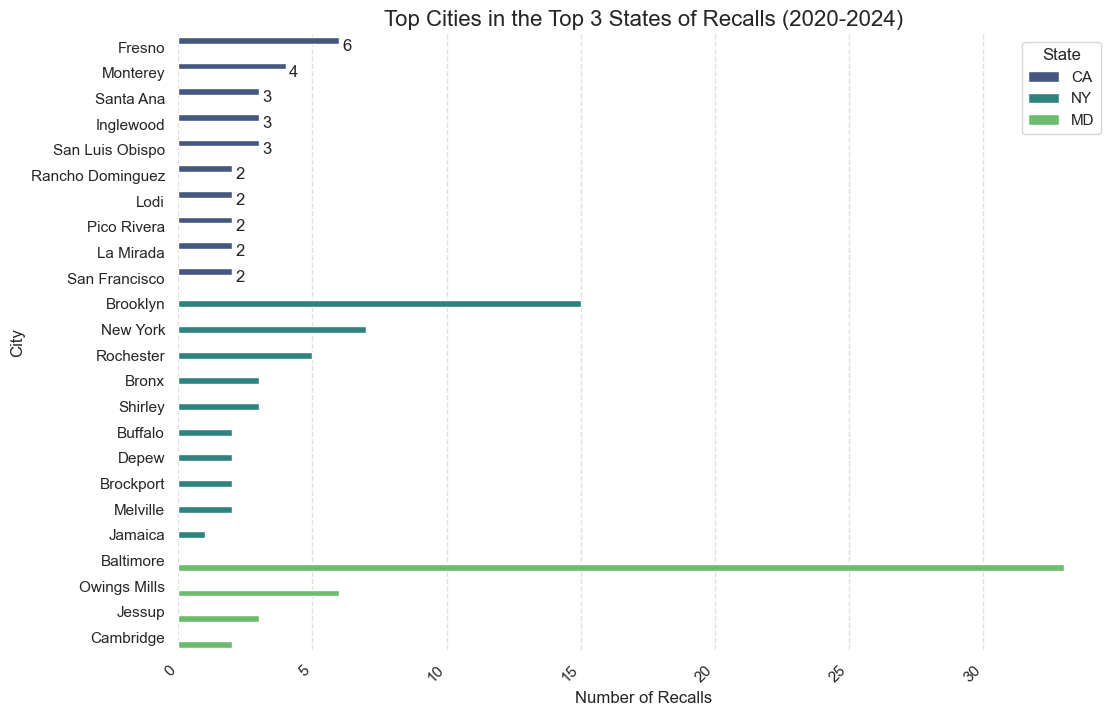

In [5]:
# Set plot style
sns.set(style="whitegrid")

# Function to plot the top cities in the top 3 states
def plot_top_3_states():
    state_counts = clean_df['State'].value_counts().reset_index()
    state_counts.columns = ['State', 'Count']

    # Get top 3 states
    top_states = state_counts.head(3)['State']
    top_cities_df = pd.DataFrame()

    # Loop through top states and get city counts
    for state in top_states:
        state_df = clean_df[clean_df['State'] == state]
        city_counts = state_df['City'].value_counts().reset_index()
        city_counts.columns = ['City', 'Count']
        city_counts['State'] = state
        top_cities_df = pd.concat([top_cities_df, city_counts.head(10)], ignore_index=True)

    # Plot the top cities in the top 3 states
    plt.figure(figsize=(12, 8))  # Ensure consistent size
    barplot = sns.barplot(x='Count', y='City', hue='State', data=top_cities_df, palette="viridis")
    plt.title('Top Cities in the Top 3 States of Recalls (2020-2024)', fontsize=16)
    plt.xlabel('Number of Recalls')
    plt.ylabel('City')
    sns.despine(left=True, bottom=True)
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, ha='right')

    # Add labels
    for p in barplot.patches:
        if int(p.get_width()) > 0:
            barplot.annotate(f'{int(p.get_width())}', (p.get_width() + 0.3, p.get_y() + 0.55), ha='center')

    plt.legend(title='State', loc='upper right')
    plt.show()

# Function to update the plot based on the selected state
def update_plot(state):
    state_df = clean_df[clean_df['State'] == state]
    city_counts = state_df['City'].value_counts().reset_index()
    city_counts.columns = ['City', 'Count']

    if not city_counts.empty:
        plt.figure(figsize=(12, 8))  
        barplot = sns.barplot(x='Count', y='City', hue='City', data=city_counts.head(10), palette="coolwarm")
        plt.title(f'Top Cities in {state} for Recalls (2020-2024)', fontsize=16)
        plt.xlabel('Number of Recalls')
        plt.ylabel('City')
        sns.despine(left=True, bottom=True)
        plt.xticks(rotation=45, ha='right')

        # Add labels
        for index, value in enumerate(city_counts['Count'].head(10)):
            barplot.text(value, index, f'{value}', color='black', va="center", fontsize=12)

        if barplot.legend_:
            barplot.legend_.remove()

        plt.show()
    else:
        print(f"No recall data available for {state}.")

# Plot the top 3 states chart
plot_top_3_states()

# Create a dropdown for state selection, sorted alphabetically
state_dropdown = widgets.Dropdown(
    options=sorted(clean_df[clean_df['Country'] == "United States"]['State'].unique()),
    description='State:',
    disabled=False,
)

#Dropdown 
widgets.interact(update_plot, state=state_dropdown);

In [16]:
# Aggregates the total number of recalls for each state
state_counts = clean_df.groupby('State')['City'].count().reset_index()
state_counts.columns = ['State', 'Recall Count']

# Identifies the city with the highest number of recalls within each state
top_city_by_state = clean_df.groupby(['State', 'City']).size().reset_index(name='City Recalls')
top_city_by_state = top_city_by_state.loc[top_city_by_state.groupby('State')['City Recalls'].idxmax()]

# Merges the total recalls per state with the highest city recalls data
state_counts = pd.merge(state_counts, top_city_by_state[['State', 'City', 'City Recalls']], on='State', how='left')

# Latitude and Longitude for state abbreviations placement
state_abbreviation_coords = {
    'AL': [32.806671, -86.791130], 'AK': [61.370716, -152.404419], 'AZ': [33.729759, -111.431221], 
    'AR': [34.969704, -92.373123], 'CA': [36.116203, -119.681564], 'CO': [39.059811, -105.311104], 
    'CT': [41.597782, -72.755371], 'DE': [39.318523, -75.507141], 'FL': [27.766279, -81.686783], 
    'GA': [33.040619, -83.643074], 'HI': [21.094318, -157.498337], 'ID': [44.240459, -114.478828], 
    'IL': [40.349457, -88.986137], 'IN': [39.849426, -86.258278], 'IA': [42.011539, -93.210526], 
    'KS': [38.526600, -96.726486], 'KY': [37.668140, -84.670067], 'LA': [31.169546, -91.867805], 
    'ME': [44.693947, -69.381927], 'MD': [39.063946, -76.802101], 'MA': [42.230171, -71.530106], 
    'MI': [43.326618, -84.536095], 'MN': [45.694454, -93.900192], 'MS': [32.741646, -89.678696], 
    'MO': [38.456085, -92.288368], 'MT': [46.921925, -110.454353], 'NE': [41.125370, -98.268082], 
    'NV': [38.313515, -117.055374], 'NH': [43.452492, -71.563896], 'NJ': [40.298904, -74.521011], 
    'NM': [34.840515, -106.248482], 'NY': [42.165726, -74.948051], 'NC': [35.630066, -79.806419], 
    'ND': [47.528912, -99.784012], 'OH': [40.388783, -82.764915], 'OK': [35.565342, -96.928917], 
    'OR': [44.572021, -122.070938], 'PA': [40.590752, -77.209755], 'RI': [41.680893, -71.511780], 
    'SC': [33.856892, -80.945007], 'SD': [44.299782, -99.438828], 'TN': [35.747845, -86.692345], 
    'TX': [31.054487, -97.563461], 'UT': [40.150032, -111.862434], 'VT': [44.045876, -72.710686], 
    'VA': [37.769337, -78.169968], 'WA': [47.400902, -121.490494], 'WV': [38.491226, -80.954456], 
    'WI': [44.268543, -89.616508], 'WY': [42.755966, -107.302490]
}

# Function to create the choropleth map that includes state abbreviations
def plot_recall_distribution_by_state():
    clear_output(wait=True)

    # Create the choropleth map
    fig = px.choropleth(
        state_counts,
        locations='State',
        locationmode="USA-states",
        color='Recall Count',
        hover_name='State',
        hover_data={
            'Recall Count': True,
            'City': True,
            'City Recalls': True
        },
        scope="usa",
        color_continuous_scale="YlOrRd",
        labels={'Recall Count': 'Total Recalls'},
        title="Total Recalls by State and Top City (2020-2024)"
    )

    # Add state abbreviations as annotations on the map
    for state, coord in state_abbreviation_coords.items():
        fig.add_trace(go.Scattergeo(
            locationmode='USA-states',
            lon=[coord[1]],
            lat=[coord[0]],
            text=state,
            mode='text',
            showlegend=False,
            textfont=dict(size=12, color="black"),
        ))

    # Updates layout for better visualization and adds a title
    fig.update_layout(
        geo=dict(
            lakecolor='rgb(255, 255, 255)',
        ),
        margin={"r":0,"t":50,"l":0,"b":0},
        title={
            'text': "Total Recalls by State and Top City (2020-2024)",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        }
    )

    fig.show()

plot_recall_distribution_by_state()

In [4]:
# Filter the DataFrame to include only recalls in the US (made a copy to avoid SettingWithCopyWarning)
us_recall_df = clean_df[clean_df['Country'] == "United States"].copy()

# Add a count column for each recall for visualization purposes
us_recall_df['Recall Count'] = 1

# Sort the top 15 recalling firms based on the number of recalls in the US
top_15_firms = (
    us_recall_df['Recalling Firm']
    .value_counts()
    .nlargest(15)
    .reset_index()
)

# Remame the columns in the identify the recall count for each
top_15_firms.columns = ['Firm Name', 'Recall Count']

# Create a list for dropdown options with the name of each firm and their recall counts
firm_options = [
    f"({row['Recall Count']}) {row['Firm Name']}"
    for _, row in top_15_firms.iterrows()
]

# Create dropdown widget for selecting a firm, including "None" as an option
firm_widget = widgets.Dropdown(
    options=[None] + firm_options,
    description='Select Firm:',
    value=None
)

# Function to create a Sunburst chart
def create_sunburst_chart(firm_with_count):
    # Extract firm name from dropdown selection
    if firm_with_count is None:
        print("Select a firm from the dropdown menu.")
        return

    try:
        # Extract the actual firm name by splitting the string
        firm = firm_with_count.split(") ")[1]
    except IndexError:
        print("Error extracting firm name from the dropdown selection.")
        return

    # Filter the data based on the selected firm
    filtered_df = us_recall_df[us_recall_df['Recalling Firm'] == firm]

    # Ensure there's data to plot
    if filtered_df.empty:
        print("No data available for the selected firm.")
        return

    # Create Sunburst chart using Plotly with customized hover information
    try:
        # Create Sunburst chart with customized hover data
        fig = px.sunburst(
            filtered_df,
            path=['Recalling Firm', 'Product Type', 'Product Description'],
            values='Recall Count',  # Use the count column for visualization
            title=f"Top Products Recalled by {firm}",
            color='Product Type',
            hover_data={
                "Classification": True,
                "Product Description": True,
                "State": True
            }
        )
        
        # Update hover template to display only the firm name
        fig.update_traces(
            hovertemplate="<br>".join([
                "Firm: " + firm,
                "Classification: %{customdata[0]}",
                "Product Description: %{customdata[1]}",
                "State: %{customdata[2]}"
            ])
        )
        
        fig.show()
        
        # Create HTML file
        fig.write_html("./output_data/fda_recalls_by_recall_firm.html")
        
        
    except Exception as e:
        print(f"An error occurred while creating the Sunburst chart: {e}")

# Create the interactive UI
interact(
    create_sunburst_chart,
    firm_with_count=firm_widget
)

interactive(children=(Dropdown(description='Select Firm:', options=(None, '(33) FRESH IDEATION FOOD GROUP, LLC…

<function __main__.create_sunburst_chart(firm_with_count)>

In [ ]:
# Close the connection
client.close()